In [2]:
import pandas as pd 
import numpy as np
import glob
from sklearn import preprocessing
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers import Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

In [3]:
filenames = glob.glob('../data/playerinfo201*')
print (filenames)

['../data\\playerInfo2010.csv', '../data\\playerInfo2011.csv', '../data\\playerInfo2012.csv', '../data\\playerInfo2013.csv', '../data\\playerInfo2014.csv', '../data\\playerInfo2015.csv', '../data\\playerInfo2016.csv', '../data\\playerInfo2017.csv']


In [198]:
dfs = []
for filename in filenames:
    df_temp = pd.read_csv(filename, error_bad_lines=False)
    dfs.append(df_temp)
    
big_df = pd.concat(dfs)
big_df[' Weight'] = big_df[' Weight'].map(lambda x: int(x[:-3]))
big_df[' Height'] = big_df[' Height'].map(lambda x: int(x[0]) * 12 + int(x[2:].rstrip('"')))

b'Skipping line 1848: expected 52 fields, saw 53\nSkipping line 6509: expected 52 fields, saw 53\n'


[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


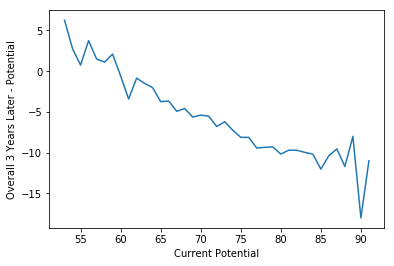

In [183]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

potential_today = []
potential_tmrw = []
potentials = {}
overalls = {}

for i in range(0, len(dfs) - 4):
    for index, row in dfs[i].iterrows():
        if row[' Potential'] - row[' Overall'] >= 10:
            new_pot = dfs[i + 3].loc[dfs[i + 3][' P_id'] == row[' P_id']][' Potential'].values
            new_ovr = dfs[i + 3].loc[dfs[i + 3][' P_id'] == row[' P_id']][' Overall'].values
            if len(new_pot) > 0:
                potential_tmrw.append(new_pot)
                potential_today.append(row[' Potential'])
                if row[' Potential'] not in potentials:
                    potentials[row[' Potential']] = list(new_pot)
                    overalls[row[' Potential']] = list(new_ovr)
                else:
                    potentials[row[' Potential']].append(new_pot[0])
                    overalls[row[' Potential']].append(new_ovr[0])
                    
#print('RMSE: ', rmse(np.asarray(potential_today), np.asarray(potential_tmrw)))
            
pot_avg_x = []
pot_avg_y = []
ovr_avg_y = []

pots = list(potentials.keys())
pots.sort()
print (pots)

for key in pots:
    pot_avg_x.append(key)
    pot_avg_y.append(np.mean(potentials[key]) - key)
    ovr_avg_y.append(np.mean(overalls[key]) - key)
#plt.plot(pot_avg_x, pot_avg_y)
#plt.scatter(potential_today, potential_tmrw)
plt.plot(pot_avg_x, ovr_avg_y)
plt.xlabel('Current Potential')
plt.ylabel('Overall 3 Years Later - Potential')
plt.legend()
plt.show()

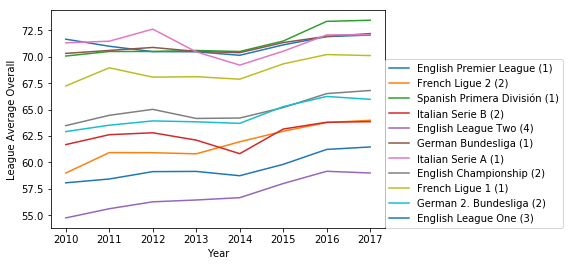

In [194]:
leagues = {}

for i in range(0, len(dfs)):
    for index, row in dfs[i].iterrows():
        if row[' League'] not in leagues:
            leagues[row[' League']] = {(i + 2010): [row[' Overall']]}
        elif ((i + 2010) not in leagues[row[' League']]):
            leagues[row[' League']][i + 2010] = [row[' Overall']]
        else:
            leagues[row[' League']][(i + 2010)].append(row[' Overall'])

for key in leagues:
    years = []
    ovrs = []
    for year in leagues[key]:
        years.append(year)
        ovrs.append(np.mean(leagues[key][year]))
    plt.plot(years, ovrs, label=key)
        
    
#plt.plot(pot_avg_x, ovr_avg_y)
plt.xlabel('Year')
plt.ylabel('League Average Overall')
plt.legend(loc=(1, 0))
plt.show()

In [199]:
means, maxs, mins = {}, {}, {}
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]
    
for i in range(len(dfs)):
    dfs[i] = dfs[i].drop(['Name', ' Game', ' Date', ' Birthday', ' Position', ' Composure'], axis=1)
    dfs[i] = dfs[i].drop(list(dfs[i].filter(regex='trait')), axis=1)
    
    '''
    lePositions = preprocessing.LabelBinarizer()
    lePositions.fit(dfs[i][' Position'])
    encodedPos = lePositions.transform(dfs[i][' Position'])
    for j in range(encodedPos.shape[1]):
        dfs[i][lePositions.classes_[j]] = encodedPos[:, j]
    dfs[i] = dfs[i].drop([' Position'], axis=1)
    dfs[i] = dfs[i].fillna(0)
    '''
    dfs[i][' Weight'] = dfs[i][' Weight'].map(lambda x: int(x[:-3]))
    dfs[i][' Height'] = dfs[i][' Height'].map(lambda x: int(x[0]) * 12 + int(x[2:].rstrip('"')))
    for colName in dfs[i].columns.drop([' P_id', ' Team', ' League']):
        dfs[i][colName] = (dfs[i][colName] - big_df[colName].mean()) / (big_df[colName].max() - big_df[colName].min())

In [200]:
dfs[0].head()

,P_id,League,Team,Age,Height,Weight,Overall,Potential,Crossing,Finishing,...,Vision,Penalties,Marking,Standing tackle,Sliding tackle,GK diving,GK handling,GK kicking,GK positioning,GK reflexes
0,135594,English Premier League (1),Stoke City,0.304836,0.268919,0.216140,0.204264,0.145691,-0.372073,-0.308735,...,-0.024116,-0.252677,-0.386718,-0.423331,-0.406605,0.649678,0.678595,0.631271,0.675178,0.684102
1,182821,French Ligue 2 (2),US Boulogne Cote D'Opale,0.014513,-0.031081,-0.016943,-0.073514,0.005341,-0.294295,-0.392068,...,-0.219769,-0.380337,-0.408696,-0.434201,-0.417357,0.486635,0.534151,0.429143,0.479525,0.555070
2,8910,English Premier League (1),Stoke City,0.369352,0.018919,0.020651,0.000560,-0.012203,-0.416517,-0.371235,...,0.051970,-0.454805,-0.254850,-0.390723,-0.309830,0.497504,0.589706,0.503611,0.555612,0.533565
3,646,English Premier League (1),Stoke City,0.272578,0.018919,-0.047018,0.074634,0.110604,0.061261,0.024598,...,0.106318,-0.071826,0.261634,0.261451,0.303073,-0.067713,-0.110294,-0.049580,-0.063953,-0.047080
4,166919,English Premier League (1),Stoke City,-0.082261,0.118919,-0.114687,0.093153,0.093060,0.016816,0.014182,...,-0.045856,-0.103741,0.316579,0.283190,0.270815,-0.045974,-0.121405,-0.028304,-0.107431,-0.090091


In [201]:
# Cleaning Data into Train and Test
train_X = dfs[0].loc[dfs[0][' P_id'].isin(dfs[1][' P_id'])]
train_Y = dfs[1].loc[dfs[1][' P_id'].isin(dfs[0][' P_id'])]
for i in range(1, len(dfs) - 2):
    train_X = train_X.append(dfs[i].loc[dfs[i][' P_id'].isin(dfs[i + 1][' P_id'])])
    train_Y = train_Y.append(dfs[i + 1].loc[dfs[i + 1][' P_id'].isin(dfs[i][' P_id'])])
test_X = dfs[-2].loc[dfs[-2][' P_id'].isin(dfs[-1][' P_id'])]
test_Y = dfs[-1].loc[dfs[-1][' P_id'].isin(dfs[-2][' P_id'])]

train_X = train_X.sort_values(by=[' P_id', ' Age']).reset_index()
train_Y = train_Y.sort_values(by=[' P_id', ' Age']).reset_index()
test_X = test_X.sort_values(by=[' P_id', ' Age']).reset_index()
test_Y = test_Y.sort_values(by=[' P_id', ' Age']).reset_index()

changedTrain = np.zeros(train_X.shape[0])
changedTest = np.zeros(test_X.shape[0])

clTrain = np.zeros(train_X.shape[0])
clTest = np.zeros(test_X.shape[0])

for index, row in train_X.iterrows():
    changedTrain[index] = 0 if row[' Team'] == train_Y.iloc[index][' Team'] else 1
    clTrain[index] = 0 if row[' League'] == train_Y.iloc[index][' League'] else 1
for indexTest, rowTest in test_X.iterrows():
    changedTest[indexTest] = 0 if rowTest[' Team'] == test_Y.iloc[indexTest][' Team'] else 1
    clTest[indexTest] = 0 if rowTest[' League'] == test_Y.iloc[indexTest][' League'] else 1
    
train_X['Changed Teams'] = changedTrain
test_X['Changed Teams'] = changedTest
train_X['Changed Leagues'] = clTrain
test_X['Changed Leagues'] = clTest

train_X = train_X.fillna(0)
test_X = test_X.fillna(0)
train_Y = train_Y.fillna(0)
test_Y = test_Y.fillna(0)

'''
for head in ['LF', 'RF', 'SW']:
    test_X[head] = np.zeros(test_X.shape[0])
'''
train_X = train_X.drop(['index', ' Team', ' League', ' P_id', ' Overall', ' Potential'], axis=1)
test_X = test_X.drop(['index', ' Team', ' League', ' P_id', ' Overall', ' Potential'], axis=1)
train_Y = train_Y.drop(['index', ' Team', ' League', ' P_id'], axis=1)
test_Y = test_Y.drop(['index', ' Team', ' League', ' P_id'], axis=1)

In [202]:
diff(train_X.columns, test_X.columns)

[]

In [203]:
test_X.columns

Index([' Age', ' Height', ' Weight', ' Crossing', ' Finishing',
       ' Heading accuracy', ' Short passing', ' Volleys', ' Dribbling',
       ' Curve', ' Free kick accuracy', ' Long passing', ' Ball control',
       ' Acceleration', ' Sprint speed', ' Agility', ' Reactions', ' Balance',
       ' Shot power', ' Jumping', ' Stamina', ' Strength', ' Long shots',
       ' Aggression', ' Interceptions', ' Positioning', ' Vision',
       ' Penalties', ' Marking', ' Standing tackle', ' Sliding tackle',
       ' GK diving', ' GK handling', ' GK kicking', ' GK positioning',
       ' GK reflexes', 'Changed Teams', 'Changed Leagues'],
      dtype='object')

In [204]:
print (train_X.shape, test_X.shape)

(28798, 38) (5034, 38)


In [205]:
train_X.head()

,Age,Height,Weight,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Dribbling,Curve,...,Marking,Standing tackle,Sliding tackle,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Changed Teams,Changed Leagues
0,0.111287,0.018919,-0.062055,0.227927,0.045432,0.153344,0.121552,0.125608,0.130187,0.232507,...,0.272623,0.261451,0.270815,-0.024235,-0.121405,-0.007027,-0.063953,-0.047080,0.0,0.0
1,0.143545,0.018919,-0.062055,0.250150,0.045432,0.068238,0.121552,0.125608,0.151021,0.221637,...,0.294601,0.294060,0.303073,-0.024235,-0.121405,-0.007027,-0.063953,-0.047080,0.0,0.0
2,0.175803,0.018919,-0.062055,0.250150,0.045432,0.068238,0.121552,0.125608,0.151021,0.221637,...,0.294601,0.294060,0.303073,-0.024235,-0.121405,-0.007027,-0.063953,-0.047080,0.0,0.0
3,0.208061,0.018919,-0.062055,0.294594,0.045432,0.068238,0.111025,0.125608,0.130187,0.221637,...,0.294601,0.283190,0.270815,-0.024235,-0.121405,-0.007027,-0.063953,-0.047080,0.0,0.0
4,0.240320,-0.031081,0.103358,0.283483,0.035015,0.057599,0.100499,0.136478,0.088521,0.210768,...,0.283612,0.272321,0.292320,-0.035104,-0.132516,-0.017665,-0.074822,-0.057833,0.0,0.0


In [206]:
train_Y.head()

,Age,Height,Weight,Overall,Potential,Crossing,Finishing,Heading accuracy,Short passing,Volleys,...,Vision,Penalties,Marking,Standing tackle,Sliding tackle,GK diving,GK handling,GK kicking,GK positioning,GK reflexes
0,0.143545,0.018919,-0.062055,0.130190,0.022884,0.250150,0.045432,0.068238,0.121552,0.125608,...,-0.154551,0.130301,0.294601,0.294060,0.303073,-0.024235,-0.121405,-0.007027,-0.063953,-0.047080
1,0.175803,0.018919,-0.062055,0.130190,0.022884,0.250150,0.045432,0.068238,0.121552,0.125608,...,-0.154551,0.130301,0.294601,0.294060,0.303073,-0.024235,-0.121405,-0.007027,-0.063953,-0.047080
2,0.208061,0.018919,-0.062055,0.056116,-0.047291,0.294594,0.045432,0.068238,0.111025,0.125608,...,-0.100203,0.130301,0.294601,0.283190,0.270815,-0.024235,-0.121405,-0.007027,-0.063953,-0.047080
3,0.240320,-0.031081,0.103358,0.037597,-0.064835,0.283483,0.035015,0.057599,0.100499,0.136478,...,-0.024116,-0.007996,0.283612,0.272321,0.292320,-0.035104,-0.132516,-0.017665,-0.074822,-0.057833
4,0.272578,-0.031081,0.103358,0.056116,-0.047291,0.272372,0.045432,0.078876,0.132078,0.147348,...,0.084579,0.002642,0.283612,0.283190,0.303073,-0.024235,-0.121405,-0.007027,-0.063953,-0.047080


In [207]:
clf = RandomForestRegressor(max_depth=50)
clf = clf.fit(train_X, train_Y[' Overall'])

print ('Error: ', rmse(clf.predict(test_X), test_Y[' Overall']))

Error:  0.0515065542402


In [208]:
clf = RandomForestRegressor(max_depth=15)
clf = clf.fit(train_X, train_Y[' Overall'])

print (clf.feature_importances_)

coefs = []
for i in range(len(clf.feature_importances_)):
    coefs.append((train_X.columns[i], clf.feature_importances_[i]))

coefs.sort(key=lambda x: x[1])
    
for i in range(len(clf.feature_importances_)):
    print (coefs[i][0], ': ', coefs[i][1])
    
print ('Error: ', rmse(clf.predict(test_X), test_Y[' Overall']))

[ 0.02122605  0.00181454  0.00309569  0.00554868  0.00773098  0.00892724
  0.00572583  0.00345829  0.00975413  0.00286889  0.00277793  0.00403249
  0.09015747  0.00390384  0.00505396  0.00317747  0.60503428  0.00356734
  0.00596144  0.00394909  0.0042094   0.0048304   0.00390713  0.00421217
  0.01400889  0.01068074  0.00368865  0.00312241  0.01211654  0.06462565
  0.00538364  0.03046719  0.0156471   0.00261108  0.00903377  0.01231615
  0.00063255  0.00074093]
Changed Teams :  0.000632553738998
Changed Leagues :  0.000740929591636
 Height :  0.00181453871215
 GK kicking :  0.00261107657668
 Free kick accuracy :  0.00277793167354
 Curve :  0.00286889299252
 Weight :  0.00309569297943
 Penalties :  0.00312240679381
 Agility :  0.00317747176057
 Volleys :  0.00345828580232
 Balance :  0.0035673430663
 Vision :  0.00368864783915
 Acceleration :  0.00390383797736
 Long shots :  0.00390712883464
 Jumping :  0.00394908625464
 Long passing :  0.00403248620822
 Stamina :  0.00420939794304
 Aggre

In [209]:
clf_lin = linear_model.LinearRegression()
clf_lin = clf_lin.fit(train_X, train_Y[' Overall'])

coefs = []
for i in range(len(clf_lin.coef_)):
    coefs.append((train_X.columns[i], clf_lin.coef_[i]))

coefs.sort(key=lambda x: x[1])
    
for i in range(len(clf_lin.coef_)):
    print (coefs[i][0], ': ', coefs[i][1])
print ('Error: ', rmse(clf_lin.predict(test_X), test_Y[' Overall']))

 Long shots :  -0.0521727043161
 Stamina :  -0.0496821737763
 Crossing :  -0.0449369649024
 Sliding tackle :  -0.0384293558298
 Balance :  -0.0279285973485
 Positioning :  -0.0166358389922
 Volleys :  -0.0130015952383
Changed Leagues :  -0.00673006255234
Changed Teams :  -0.00218456521709
 Dribbling :  0.000967159550856
 Age :  0.00253167043781
 Free kick accuracy :  0.00264727113001
 Vision :  0.0114865237423
 Height :  0.0133911018954
 Standing tackle :  0.0171435030863
 Penalties :  0.0180649533667
 Agility :  0.0182296055783
 Long passing :  0.0202091129813
 Jumping :  0.0206611648791
 Aggression :  0.0222964495754
 Strength :  0.0237062520503
 Finishing :  0.0301475286038
 Weight :  0.0320085505862
 Marking :  0.0417753714384
 Shot power :  0.0420566476547
 Curve :  0.0453142336175
 GK kicking :  0.0750957002282
 Acceleration :  0.076580891533
 Sprint speed :  0.0797273277147
 Interceptions :  0.0840037546084
 GK reflexes :  0.0977270320154
 Short passing :  0.109454239571
 GK han

In [ ]:
train_X = train_X[' Overall']
test_X = test_X[' Overall']
print (train_X)

clf_lin_2 = linear_model.LinearRegression()
clf_lin_2 = clf_lin_2.fit(train_X, train_Y[' Overall'])

print ('Error: ', rmse(clf_lin.predict(test_X), test_Y[' Overall']))

In [23]:
clf_SVM = svm.SVR()
clf_SVM = clf_SVM.fit(train_X, train_Y[' Overall'])

print ('Error: ', rmse(clf_SVM.predict(test_X), test_Y[' Overall']))

Error:  0.101127482459


In [28]:
clf_K = KNeighborsRegressor()
clf_K = clf_K.fit(train_X, train_Y[' Overall'])

print ('Error: ', rmse(clf_K.predict(test_X), test_Y[' Overall']))

Error:  0.105634746732


In [24]:
print ('Error: ', rmse(train_X[' Overall'].values, train_Y[' Overall'].values))

Error:  0.0600264023781


In [21]:
print('Overall Error: ', ((big_df[' Overall'].max() - big_df[' Overall'].min()) * 0.044))

Overall Error:  2.376
